In [1]:
from torchvision.models._utils import IntermediateLayerGetter
import torch
from torch import Tensor
from collections import namedtuple
from collections import OrderedDict
from torch import nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import VOCDetection
import torch.optim as optim
import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import imageio
import math
from torchvision.transforms import Resize
import matplotlib.pyplot as plt
import numpy as np
from easydict import EasyDict as edict
import tensorflow as tf
from IPython import display
import random
from torch.autograd.function import once_differentiable
from torch.autograd import Function
from torchvision.models import resnet50
from torchvision.ops.boxes import box_area
from scipy.optimize import linear_sum_assignment
import copy
import matplotlib.font_manager as fm # to create font

In [2]:
from typing import Optional, List
fontsize = 24
FONT = ImageFont.truetype(fm.findfont(fm.FontProperties(family='DejaVu Sans')),fontsize)

In [3]:
resnet50=resnet50(pretrained=True)
resnet=nn.Sequential(*list(resnet50.children()))[:-2]

In [4]:
class NestedTensor(object):
    
    def __init__(self,tensors,mask:Optional[Tensor]):
        
        self.tensors=tensors
        self.mask=mask
        
    def to(self,device):
        
        cast_tensor=self.tensors.to(device)
        
        if mask is not None:
            cast_mask=mask.to(device)
            
        else:
            cast_mask=None
        
        return NestedTensor(cast_tensor,cast_mask)
    
    def decompose(self):
        
        return self.tensors,self.mask
    def __repr__(self):
        
        return str(self.tensors)
    
    

In [5]:
class PositionEmbeddingSine(nn.Module):
    
    def __init__(self,num_pos_feats=64,temperature=10000,normalize=False,scale=False):
        
        super(PositionEmbeddingSine,self).__init__()
        
        self.num_pos_feats=num_pos_feats
        self.temperature=temperature
        self.normalize=normalize
        
        if scale is None:
            
            scale=2*math.pi
            
        self.scale=scale
    
    def forward(self,tensor):
        
        x=tensor
       # mask=tensor_list.mask
        
        not_mask=torch.ones(x.shape[-2:],device='cuda')
        not_mask=not_mask[None,:,:]
        y_embed=not_mask.cumsum(1,dtype=torch.float32).to('cuda')
        x_embed=not_mask.cumsum(2,dtype=torch.float32).to('cuda')
        if self.normalize:
            
            eps=1e-6
            y_embed=y_embed/(y_embed[:,-1:,:]+eps)*self.scale
            x_embed=x_embed/(x_embed[:,:,-1:]+eps)*self.scale
            
        dim_t=torch.arange(self.num_pos_feats,dtype=torch.float32).to('cuda')
        dim_t=self.temperature**(2*(dim_t//2)/self.num_pos_feats)
        
        pos_x=x_embed[:,:,:,None]/dim_t
        pos_y=y_embed[:,:,:,None]/dim_t
        
        pox_x=torch.stack((pos_x[:,:,:,0::2].sin(),pos_x[:,:,:,0::2].cos()),dim=4).flatten(3)
        pos_y=torch.stack((pos_y[:,:,:,0::2].sin(),pos_y[:,:,:,0::2].cos()),dim=4).flatten(3)
        
        pos=torch.cat((pos_x,pos_y),dim=3).permute(0,3,1,2)
        return pos

In [6]:
def bulid_position_encoding():
    
    N_steps=256
    position_embedding=PositionEmbeddingSine(N_steps,normalize=True)
    
    return position_embedding

In [7]:
class FrozenBatchNorm2d(nn.Module):
    
    def __init__(self,n):
        super(FrozenBatchNorm2d,self).__init__()
        
        self.register_buffer("weight",torch.ones(n))
        self.register_buffer("bias",torch.zeros(n))
        self.register_buffer("running_mean",torch.zeros(n))
        self.register_buffer("running_var",torch.ones(n))
        
    def forward(self,x):
        
        w=self.weight.reshape(1,-1,1,1)
        b=self.bias.reshape(1,-1,1,1)
        rv=self.running_var.reshape(1,-1,1,1)
        rm=self.running_mean.reshape(1,-1,1,1)
        
        eps=1e-5
        scales=w*(rv+eps).rsqrt()
        bias=b-rm*scales
        
        return x*scales*bias

In [8]:
resnet[7][2].bn1=FrozenBatchNorm2d(512)
resnet[7][2].bn2=FrozenBatchNorm2d(512)
resnet[7][2].bn3=FrozenBatchNorm2d(2048)

In [9]:
class backbone(nn.Module):
    def __init__(self):
        super(backbone,self).__init__()
        self.resnet=resnet
    def forward(self,x):
        x=x.type(torch.cuda.FloatTensor)
        out=self.resnet(x)
        pos=bulid_position_encoding()(out)
        return out,pos


In [10]:
class TransformerEncoderLayer(nn.Module):
    
    def __init__(self,d_model,n_head,dim_feedforward=2048,dropout=0.1,\
                 normalize_before=False):
        
        super(TransformerEncoderLayer,self).__init__()
        
        self.d_model=d_model
        self.self_attn=nn.MultiheadAttention(d_model,n_head,dropout=dropout)
        self.linear1=nn.Linear(d_model,dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.dropout=nn.Dropout(dropout)
        
        self.norm1=nn.LayerNorm(d_model)
        self.norm2=nn.LayerNorm(d_model)
        self.dropout1=nn.Dropout(dropout)
        self.dropout2=nn.Dropout(dropout)
        
        self.activation=nn.ReLU()
        self.normalize_before=normalize_before
    def with_pos_embed(self,tensor,pos=None):
        
        return tensor if pos is None else tensor+pos
    def forward_pre(self,scr,pos):
        
        scr2=self.norm1(scr)
        q=k=self.with_pos_embed(scr2,pos)
        scr2=self.self_attn(q,k,value=scr2)[0]
        scr=scr+self.dropout1(scr2)
        scr2=self.norm2(scr)
        scr2=self.linear2(self.dropout(self.activation(self.linear1(scr2))))
        scr=scr+self.dropout2(scr2)
        
        return scr
    def forward_post(self,scr,pos):
        
        q=k=self.with_pos_embed(scr,pos)
        scr2=self.self_attn(q,k,value=scr)[0]
        
        scr=scr+self.dropout1(scr2)
        scr=self.norm1(scr)
        scr2=self.linear2(self.dropout(self.activation(self.linear1(scr))))
        scr=scr+self.dropout2(scr2)
        scr=self.norm2(scr)
        return scr
    def forward(self,scr,pos):
       
        if self.normalize_before:
            
            return self.forward_pre(scr,pos)
        else:
            return self.forward_post(scr,pos)
        
        

In [11]:
def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [12]:
class TransformerEncoder(nn.Module):
    
    def __init__(self,encoder_layer,num_layers,norm=None):
        
        
        super(TransformerEncoder,self).__init__()
        layers=[]
        #for i in range(num_layers):
            
        #    layers.append(encoder_layer)
            
        #self.add_module("layer",nn.Sequential(*layers))
        self.layers = _get_clones(encoder_layer, num_layers)
        self.norm=norm
        
    def forward(self,scr,pos):
        output=scr
        for layer in self.layers:
            output=layer(output,pos)
        #out=self.layers(pos,scr)

        if self.norm is not None:
            output=self.norm(output)
        return output

In [13]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self,d_model,n_head,dim_feedforward=2048,dropout=0.1,normalize_before=False):
        
        super(TransformerDecoderLayer,self).__init__()
        self.self_attn=nn.MultiheadAttention(d_model,n_head,dropout)
        self.multihead_attn=nn.MultiheadAttention(d_model,n_head,dropout)
        
        self.linear1=nn.Linear(d_model,dim_feedforward)
        self.dropout=nn.Dropout(dropout)
        self.linear2=nn.Linear(dim_feedforward,d_model)
        
        self.norm1=nn.LayerNorm(d_model)
        self.norm2=nn.LayerNorm(d_model)
        self.norm3=nn.LayerNorm(d_model)
        self.dropout1=nn.Dropout(dropout)
        self.dropout2=nn.Dropout(dropout)
        self.dropout3=nn.Dropout(dropout)
        
        self.activation=nn.ReLU()
        self.normalize_before=normalize_before
        
    def with_pos_embed(self,tensor,pos=None):
        return tensor if pos is None else pos+tensor
    
    def forward_post(self,tgt,memory,pos,query_pos):
        q=k=self.with_pos_embed(tgt,query_pos)
        
        tgt2=self.self_attn(q,k,value=tgt)[0]
        tgt=tgt+self.dropout1(tgt2)
        tgt=self.norm1(tgt)
        tgt2=self.multihead_attn(query=self.with_pos_embed(tgt,query_pos),\
                                key=self.with_pos_embed(memory,pos),\
                                value=memory)[0]
        
        tgt=tgt+self.dropout2(tgt2)
        tgt=self.norm2(tgt)
        tgt2=self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt=tgt+self.dropout3(tgt2)
        
        tgt=self.norm3(tgt)
        return tgt
    def forward_pre(self,tgt,memory,query_pos):
        tgt2=self.norm1(tgt)
        q=k=self.with_pos_embed(tgt2,query_pos)
        
        tgt2=self.self_attn(q,k,value=tgt2)[0]
        tgt=tgt+self.dropout1(tgt2)
        tgt2=self.norm2(tgt)
        tgt2=self.multihead_attn(query=self.with_pos_embed(tgt2,query_pos),\
                                key=self.with_pos_embed(memory,pos),\
                                value=memory)[0]
        tgt=tgt+self.dropout2(tgt2)
        
        tgt2=self.norm3(tgt)
        tgt2=self.linear2(self.dropout(self.activation(self.linear1(tgt2))))
        tgt=tgt+self.dropout3(tgt2)
        return tgt
    
    def forward(self,tgt,memory,pos,query_pos):
        
        if self.normalize_before:
            return self.forward_pre(tgt,memory,pos,query_pos)
        else:
            return self.forward_post(tgt,memory,pos,query_pos)

In [14]:
class TransformerDecoder(nn.Module):
    def __init__(self,decoder_layer,num_layers,norm=None,return_intermediate=True):
        super(TransformerDecoder,self).__init__()
        layers=[]
        for i in range(num_layers):
            self.add_module("layer{}".format(i),decoder_layer)
            layers.append("layer{}".format(i))
        self.layers=layers
        self.num_layers=num_layers
        self.norm=norm
        self.return_intermediate=return_intermediate
        
    def forward(self,tgt,memory,pos,query_pos):
        
        output=tgt
        intermediate=[]
        
        for i in range(self.num_layers):
            
            output=getattr(self,self.layers[i])(output,memory,pos,query_pos)
            if self.return_intermediate:
                intermediate.append(self.norm(output))
                
        if self.norm is not None:
            output=self.norm(output)
            if self.return_intermediate:
                intermediate.pop()
                intermediate.append(output)
        if self.return_intermediate:
            return torch.stack(intermediate)
        return output.unsqueeze(0)  

In [15]:
class Transformer(nn.Module):
    
    def __init__(self,d_model=512,n_head=8,num_encoder_layers=6,\
                num_decoder_layers=6,dim_feedforward=2048,dropout=0.1,normalize_before=False,return_intermediate=True):
        
        super(Transformer,self).__init__()
        
        encoder_layer=TransformerEncoderLayer(d_model,n_head,dim_feedforward,dropout,normalize_before)
        encoder_norm=nn.LayerNorm(d_model) if normalize_before else None
        self.encoder=TransformerEncoder(encoder_layer,num_encoder_layers,encoder_norm)
        
        decoder_layer=TransformerDecoderLayer(d_model,n_head,dim_feedforward,dropout,normalize_before)
        decoder_norm=nn.LayerNorm(d_model)
        self.decoder=TransformerDecoder(decoder_layer,num_decoder_layers,decoder_norm,return_intermediate=return_intermediate)
        self.d_model=d_model
        self.n_head=n_head
        
    def forward(self,src,query_embed,pos_embed):
        
        bs,c,h,w=src.shape
        src=src.flatten(2).permute(2,0,1)#(56,1,512)
        pos_embed=pos_embed.flatten(2).permute(2,0,1)
        query_embed=query_embed.unsqueeze(1).repeat(1,bs,1)
        tgt=torch.zeros_like(query_embed,device='cuda')
        memory=self.encoder(src,pos_embed)
        hs=self.decoder(tgt,memory,pos_embed,query_embed)#(6,100,2,512)
        
        return hs.transpose(1,2),memory.permute(1,2,0).view(bs,c,h,w)


In [16]:
class FFN(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,num_layers):
        super(FFN,self).__init__()
        self.num_layers=num_layers
        h=[hidden_dim]*(num_layers-1)
        self.layers=nn.ModuleList(nn.Linear(n,k) for n,k in zip([input_dim]+h,h+[output_dim]))
        
    def forward(self,x):
        for i,layer in enumerate(self.layers):
            
            x=F.relu(layer(x)) if i<self.num_layers-1 else layer(x)
            
        return x

In [17]:
def box_cxcywh_to_xyxy(x):
    x_c,y_c,w,h=x.unbind(-1)
    b=[(x_c-0.5*w),(y_c-0.5*h),(x_c+0.5*w),(y_c+0.5*h)]
    return torch.stack(b,dim=1)

In [18]:
def build_transformer():
    return Transformer(
    d_model=512,
    dropout=0.1,
    n_head=8,
    dim_feedforward=2048,
    num_encoder_layers=6,
    num_decoder_layers=6,
    normalize_before=True,
    return_intermediate=True)

In [19]:
def box_iou(box1,box2):
    area1=box_area(box1)
    area2=box_area(box2)
    
    lt=torch.max(box1[:,None,:2],box2[:,:2])
    rb=torch.min(box1[:,None,2:],box2[:,2:])
    
    wh=(rb-lt).clamp(min=0)
    inter=wh[:,:,0]*wh[:,:,1]
    union=area1[:,None]+area2-inter
    iou=inter/union
    
    return iou,union
    

In [20]:
def generalized_box_iou(box1,box2):
    
    iou,union=box_iou(box1,box2)
    
    lt=torch.min(box1[:,None,:2],box2[:,:2])
    rb=torch.max(box1[:,None,2:],box2[:,2:])
    
    wh=(rb-lt).clamp(min=0)
    
    area=wh[:,:,0]*wh[:,:,1]
    
    return iou-(area-union)/area
    
    

In [21]:
class HungarianMatcher(nn.Module):
    
    def __init__(self,cost_class=1,cost_box=1,cost_giou=1):
        super(HungarianMatcher,self).__init__()
        
        self.cost_class=cost_class
        self.cost_box=cost_box
        self.cost_giou=cost_giou
    @torch.no_grad()
    def forward(self,outputs,targets):
        bs,num_queries=outputs["pred_logits"].shape[:2]
        out_prod=outputs["pred_logits"].flatten(0,1).softmax(-1)#100 21
        out_box=outputs["pred_boxes"].flatten(0,1).type(torch.float64)#100 4
     

        tgt_ids=torch.cat([v["labels"] for v in targets])#2
        tgt_box=torch.cat([v["boxes"] for v in targets]).type(torch.float64)#2 4
        
       
        cost_class=-out_prod[:,tgt_ids]
        cost_box=torch.cdist(out_box,tgt_box,p=1)
        

        cost_giou=-generalized_box_iou(box_cxcywh_to_xyxy(out_box),box_cxcywh_to_xyxy(tgt_box))
        C=self.cost_class*cost_class+self.cost_box*cost_box+self.cost_giou*cost_giou
        
        C=C.reshape(bs,num_queries,-1).cpu()[0]
        #sizes=[len(v["boxes"]) for v in targets]
        i,j=linear_sum_assignment(C)
        return [(torch.as_tensor(i,dtype=torch.int64),torch.as_tensor(j,dtype=torch.int64))]
        
        
        

In [22]:
def build_matcher():
    return HungarianMatcher(cost_class=1,cost_box=5,cost_giou=2)

In [23]:
class DETR(nn.Module):
    def __init__(self,backbone,transformer,num_classes,num_queries,aux_loss=False):
        
        super(DETR,self).__init__()
        
        self.num_queries=num_queries
        self.transformer=transformer()
        hidden_dim=transformer().d_model
        self.class_embed=nn.Linear(hidden_dim,num_classes+1)
        self.box_embed=FFN(hidden_dim,hidden_dim,4,3)
        self.query_embed=nn.Embedding(num_queries,hidden_dim)
        self.input_proj=nn.Conv2d(2048,hidden_dim,kernel_size=1)
        self.backbone=backbone()
        self.aux_loss=aux_loss
    def _set_aux_loss(self,output_class,output_coord):
        return[{"pred_logits":a,"pred_boxes":b} for a,b in zip(output_class[:-1],output_coord[:-1])]
        
    def forward(self,x):
        
        feature,pos=self.backbone(x)
        src=feature
        hs=self.transformer(self.input_proj(src),self.query_embed.weight,pos)[0]
        
        output_class=self.class_embed(hs)#(6,2,100,512)->(6,2,100,21)
        output_coord=self.box_embed(hs).sigmoid()
        
        out={"pred_logits":output_class[-1],"pred_boxes":output_coord[-1]}#(1,100,21)
        
        if self.aux_loss:
            out["aux_outputs"]=self._set_aux_loss(output_class,output_coord)
        return out
        

In [24]:
class SetCriterion(nn.Module):
    
    def __init__(self,num_classes,matcher,losses):
        super(SetCriterion,self).__init__()
        
        self.num_classes=num_classes
        self.matcher=matcher
        self.losses=losses
        #empty_weight=torch.ones(self.num_classes+1)
        #empty_weight[-1]=self.eos_coef
        #self.register_buffer("empty_weight",empty_weight)
    def _get_src_permutation_idx(self,indices):
        batch_idx=torch.cat([torch.full_like(src,i,device='cuda') for i ,(src,_) in enumerate(indices)])
        src_idx=torch.cat([src for (src,_) in indices])
        return batch_idx,src_idx
    def _get_tgt_permutation_idx(self,indices):
        
        batch_idx=torch.cat([torch.full_like(tgt,i,device='cuda') for i ,(_,tgt) in enumerate(indices)])
        tgt_idx=torch.cat([tgt for (_,tgt) in indices])
        
        return batch_idx,tgt_idx
    def loss_labels(self,outputs,targets,indices,num_boxes):
        
        
        src_logits=outputs["pred_logits"]#(1,100,21)
        idx=self._get_src_permutation_idx(indices)
        

        target_classes_o=torch.cat([t["labels"][j] for t,(_,j) in zip (targets,indices)])
        target_classes=torch.full(src_logits.shape[:2],self.num_classes,dtype=torch.int64,device=src_logits.device)
        target_classes[idx]=target_classes_o
       
        loss_ce=F.cross_entropy(src_logits.transpose(1,2),target_classes)
        losses={"loss_ce":loss_ce}
        
        return losses
    
    def loss_boxes(self,outputs,targets,indices,num_boxes):
        
        idx=self._get_src_permutation_idx(indices)
       
        src_boxes=outputs["pred_boxes"][idx]
        target_boxes=torch.cat([t["boxes"][i] for t,(_,i) in zip(targets,indices)],dim=0)
        #print(target_boxes)
        losses={}
        loss_bbox=F.l1_loss(src_boxes,target_boxes,reduction='none')
        
        losses["loss_bbox"]=loss_bbox.sum()/num_boxes
       
        loss_giou=1-torch.diag(generalized_box_iou(box_cxcywh_to_xyxy(src_boxes),box_cxcywh_to_xyxy(target_boxes)))
        
        losses["loss_giou"]=loss_giou.sum()/num_boxes
        
        return losses
    def get_loss(self,loss,outputs,targets,indices,num_boxes):
        
        loss_map={
            "labels":self.loss_labels,
            "boxes":self.loss_boxes
        }
        return loss_map[loss](outputs,targets,indices,num_boxes)
    def forward(self,outputs,targets):
        #time.sleep(100)

        outputs_without_aux={k:v for k,v in outputs.items() if k!="aux_outputs"}
        #print(outputs_without_aux)
        #time.sleep(100)
        indices=self.matcher(outputs_without_aux,targets)#[(),()]
        
        num_boxes=sum(len(t["labels"]) for t in targets)
        num_boxes=torch.as_tensor([num_boxes],dtype=torch.float64,device=next(iter(outputs.values())).device)
        losses={}
        for loss in self.losses:
            losses.update(self.get_loss(loss,outputs,targets,indices,num_boxes))
        if "aux_outputs" in outputs:
            
            for i,aux_outputs in enumerate(outputs["aux_outputs"]):
                indices=self.matcher(aux_outputs,targets)
                for loss in self.losses:
                    
                    l_dict=self.get_loss(loss,aux_outputs,targets,indices,num_boxes)
                    l_dict={k + f'_{i}': v for k, v in l_dict.items()}
                    losses.update(l_dict)
        return losses

In [25]:
class PostProcess(nn.Module):
    
    @torch.no_grad()
    def forward(self,outputs,target_sizes):
        
        out_logits,out_bbox=outputs["pred_logits"][0],outputs["pred_boxes"][0]
        prod=F.softmax(out_logits,-1)#(1,100,21)
        scores,labels=prod[...,:-1].max(-1)#(1,100)
        boxes=box_cxcywh_to_xyxy(out_bbox)
        
        img_h,img_w=target_sizes.unbind(1)
        scale_fct=torch.stack([img_w,img_h,img_w,img_h],dim=1).to('cuda')
        boxes=boxes*scale_fct#(2,100,4)
        
        results={"scores":scores,"labels":labels,"boxes":boxes}
        
        return results

In [26]:
net=DETR(backbone,Transformer,20,10,aux_loss=True).to('cuda')
optimizer = optim.Adam(net.parameters(), lr=0.00001) #设置优化器和学习率

In [27]:
def draw_one(images,xmin,ymin,xmax,ymax,display_str,font,color='red',thickness=1):
        
    draw = ImageDraw.Draw(images)
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
    text_bottom = top
    text_width, text_height = font.getsize(display_str)
    #print(text_width,text_height)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
      [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                        text_bottom)],
      fill=color)
    draw.text(
      (left + margin, text_bottom - text_height - margin),
      display_str,
      fill='black',
      font=font)

    return images
def draw_it(image,labels,box):
    
    num_box=box.size()[0]
    image=torch.squeeze(image)
    image=image.permute(1,2,0)
    image=image.to('cpu').numpy()
    image=np.round((image*0.5+0.5)*255)
    image=image.astype(np.uint8)
    image=Image.fromarray(image)
    for i in range(num_box):
        the_class=labels[i]
        xmin,ymin,xmax,ymax=box[i,0],box[i,1],box[i,2],box[i,3]
        image=draw_one(image,xmin,ymin,xmax,ymax,'%s'%(the_class),FONT)
    image=torch.tensor(np.array(image))  
    return image   

In [28]:
train_tramforms=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [29]:
train=VOCDetection('C:/数据/目标检测voc2007/',year='2007',image_set='train',download=False,transform=train_tramforms)

In [30]:
def get_coo_image(train):
    data_set=[]
    images=[]
    for i in range(len(train)):
        #i=245
        #label=0
        #if i==707:
         #   pass
        if i in [707,1660]:
            continue
        data=[]
        for j in range(len(train[i][1]['annotation']['object'])):
        
            xmin=int(train[i][1]['annotation']['object'][j]['bndbox']['xmin'])
            ymin=int(train[i][1]['annotation']['object'][j]['bndbox']['ymin'])
            xmax=int(train[i][1]['annotation']['object'][j]['bndbox']['xmax'])
            ymax=int(train[i][1]['annotation']['object'][j]['bndbox']['ymax'])
            name=train[i][1]['annotation']['object'][j]['name']
           # if (xmax-xmin)<150 or (ymax-ymin)<150:
           #     label=1
           #     break
            data.append([xmin,ymin,xmax,ymax,name])
            
       
        image=train[i][0]
       # if label!=1:
        data_set.append(data)
        images.append(image)
        #if i==245:
        #    break

        
        
    return data_set,images

In [31]:
datasets1,images1=get_coo_image(train)
name=['cow', 'aeroplane', 'bottle', 'bird', 'motorbike', 'person', 'tvmonitor', 'sofa', 'car', 'boat', 'cat', 'horse', 'train', 'bus', 'bicycle', 'chair', 'dog', 'pottedplant', 'sheep', 'diningtable','nan']

In [32]:
dataset=datasets1

In [33]:
for i in range(len(dataset)):
    for j in range(len(dataset[i])):
        dataset[i][j][-1]=name.index(dataset[i][j][-1])

In [34]:
def train_rcnn(epoches,images,datasets):
    
    length=len(datasets)
    net.train()
    for i_2 in range(epoches):
        num=0
        for j in range(len(images)-100):

            print("epocges:%d    "%(i_2),"num:%d   "%(j),end="\r")
            optimizer.zero_grad()
            image=images[j]
            image=image.unsqueeze(0).to('cuda')
            n1,c1,h1,w1=image.size()
            gt_box=torch.tensor(datasets[j])
            #gt_box[:,0]=gt_box[:,0]/w1
            #gt_box[:,1]=gt_box[:,1]/h1
            #gt_box[:,2]=gt_box[:,2]/w1
            #gt_box[:,3]=gt_box[:,3]/h1
            l,t,r,b=gt_box[:,0],gt_box[:,1],gt_box[:,2],gt_box[:3]
            gt=torch.zeros_like(gt_box[:,:-1],dtype=torch.float64)
            gt[:,0]=((gt_box[:,0]+gt_box[:,2])/2)/w1
            gt[:,1]=((gt_box[:,1]+gt_box[:,3])/2)/h1
            gt[:,2]=(gt_box[:,2]-gt_box[:,0]+1)/w1
            gt[:,3]=(gt_box[:,3]-gt_box[:,1]+1)/h1
            gt=gt.to('cuda')
            gt_box=gt_box.to('cuda')
            #targets=gt_box[:,:-1]
            #labels_targets=gt_box[:,-1]
            #image = image.to(device)
           # gt_box = gt_box.to(device)
            targets={
                    "labels":gt_box[:,-1],
                    "boxes":gt  
                }
            out=net(image)
            losses=SetCriterion(20,HungarianMatcher(),["labels","boxes"])(out,[targets])

            loss=0
            for i in losses.keys():
                loss=loss+losses[i]
            loss.backward()
            optimizer.step()
            if j%300==0:
                """
                测试一张图片
                """
                test_num=random.randint(2400,2498)
                #test_num=j
                image=images[test_num]
                image=image.unsqueeze(0)

                n1,c1,h1,w1=image.size()
               
                image_sizes=torch.tensor([[h1,w1]])
                out=net(image)
                results=PostProcess()(out,image_sizes)
                scores=results["scores"].to('cpu')
                labels=results["labels"].to('cpu')
                boxes=results["boxes"].to('cpu')
                #print(boxes,end='\r')
                cls_prod=scores
                index2=torch.where(scores>0.3)[0]
                boxes=boxes[index2]
                labels=labels[index2]
                if len(index2)<=1:
                    pass
                else:
                    #print(labels)

                    display.clear_output(wait=True)

                    list_name=[]
                    for i in range(len(labels)):
                        list_name.append(labels[i])
                    #list_name=torch.tensor(list_name)

                    list_names=[]

                    for i in range(len(list_name)):
                        list_names.append(name[list_name[i]])


                    boxes=torch.round(boxes).type(torch.int)
                    image=draw_it(image,list_names,boxes)
                    image=torch.squeeze(image.to('cpu'))
                    plt.imshow(image)
                    plt.show()

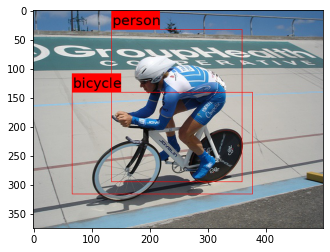

In [ ]:
train_rcnn(1000,images1,dataset)